In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
import xarray as xr

In [2]:
# psu, temp, chfa and fdom fluorescence.
# 58.9 – 59.7
# separate file for chl-a

In [2]:
lat1 = 58.9
lat2 = 59.9

## Read data

In [3]:
df = pd.read_csv('FA_2023-01-01T00_00_00_2023-12-30T00_00_00.csv', parse_dates=['time'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433688 entries, 0 to 433687
Data columns (total 8 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   index                                      433688 non-null  int64         
 1   time                                       433688 non-null  datetime64[ns]
 2   FA/INLET/SBE38/TEMPERATURE/RAW             433688 non-null  float64       
 3   FA/FERRYBOX/SBE45/SALINITY/RAW             433688 non-null  float64       
 4   FA/FERRYBOX/C3/CDOM_FLUORESCENCE/ADJUSTED  433688 non-null  float64       
 5   FA/FERRYBOX/C3/CHLA_FLUORESCENCE/ADJUSTED  433688 non-null  float64       
 6   longitude                                  433688 non-null  float64       
 7   latitude                                   433688 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 26.5 MB


In [5]:
df = df[(df['latitude'] >= lat1) & (df['latitude'] <= lat2)]

<Axes: xlabel='longitude', ylabel='latitude'>

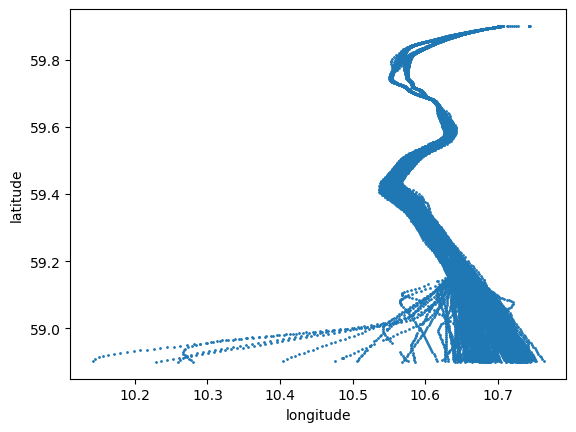

In [6]:
df.plot('longitude', 'latitude', kind='scatter', s=1)

In [7]:
# mask to hide perids with no data
dmask = ( ((df['time'] > '2023-01-10') & (df['time'] < '2023-02-20')) )
df = df[~dmask]

In [8]:
df = df.dropna()

In [9]:
df.describe().to_excel('fb_info.xlsx')

In [10]:
names = ['FA/INLET/SBE38/TEMPERATURE/RAW', 'FA/FERRYBOX/SBE45/SALINITY/RAW',
       'FA/FERRYBOX/C3/CDOM_FLUORESCENCE/ADJUSTED', 'FA/FERRYBOX/C3/CHLA_FLUORESCENCE/ADJUSTED']

In [11]:
cmaps = dict(zip(names, ['RdYlBu_r', 'viridis_r', 'YlOrBr', 'YlGn']))
labels = dict(zip(names, ['Temperatur, °C', 'Saltholdighet, PSU', 'CDOM fluorescens', 'Klorofyll-a (µg/L)']))
fignames = dict(zip(names, ['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll']))

In [12]:
cmaps

{'FA/INLET/SBE38/TEMPERATURE/RAW': 'RdYlBu_r',
 'FA/FERRYBOX/SBE45/SALINITY/RAW': 'viridis_r',
 'FA/FERRYBOX/C3/CDOM_FLUORESCENCE/ADJUSTED': 'YlOrBr',
 'FA/FERRYBOX/C3/CHLA_FLUORESCENCE/ADJUSTED': 'YlGn'}

## Create regular time-lat grid

In [13]:
# original time and lats
tsec = abs((df['time'].iloc[0] - df['time']).dt.total_seconds().to_numpy())/60 # in minutes from beginning
lat = df['latitude'].to_numpy()

In [14]:
# time and lat with regular step
tsec_reg = np.arange(0, tsec[-1], 10) # 10 minutes # WE DIVIDE HERE TO MAKE EUCLIDIAN DISTANCES CLOSER TO EACH OTHER (WITH LAT)
lat_reg = np.linspace(lat1, lat2, 101)

In [15]:
tsec_reg.shape

(52003,)

In [16]:
lat_reg

array([58.9 , 58.91, 58.92, 58.93, 58.94, 58.95, 58.96, 58.97, 58.98,
       58.99, 59.  , 59.01, 59.02, 59.03, 59.04, 59.05, 59.06, 59.07,
       59.08, 59.09, 59.1 , 59.11, 59.12, 59.13, 59.14, 59.15, 59.16,
       59.17, 59.18, 59.19, 59.2 , 59.21, 59.22, 59.23, 59.24, 59.25,
       59.26, 59.27, 59.28, 59.29, 59.3 , 59.31, 59.32, 59.33, 59.34,
       59.35, 59.36, 59.37, 59.38, 59.39, 59.4 , 59.41, 59.42, 59.43,
       59.44, 59.45, 59.46, 59.47, 59.48, 59.49, 59.5 , 59.51, 59.52,
       59.53, 59.54, 59.55, 59.56, 59.57, 59.58, 59.59, 59.6 , 59.61,
       59.62, 59.63, 59.64, 59.65, 59.66, 59.67, 59.68, 59.69, 59.7 ,
       59.71, 59.72, 59.73, 59.74, 59.75, 59.76, 59.77, 59.78, 59.79,
       59.8 , 59.81, 59.82, 59.83, 59.84, 59.85, 59.86, 59.87, 59.88,
       59.89, 59.9 ])

In [17]:
# create 2D grid
tsec_regm, lat_regm = np.meshgrid(tsec_reg,lat_reg)

In [18]:
# create timesteps for plotting interpolated fields
dates = pd.date_range(start=df['time'].iloc[0], freq='10min', periods=tsec_reg.shape[0])

In [19]:
# mask to hide perids with no data
# mask = (dates < '2023-02-20')

In [21]:
vmaxdict = dict(zip(names, [25, 32, 30, 10]))

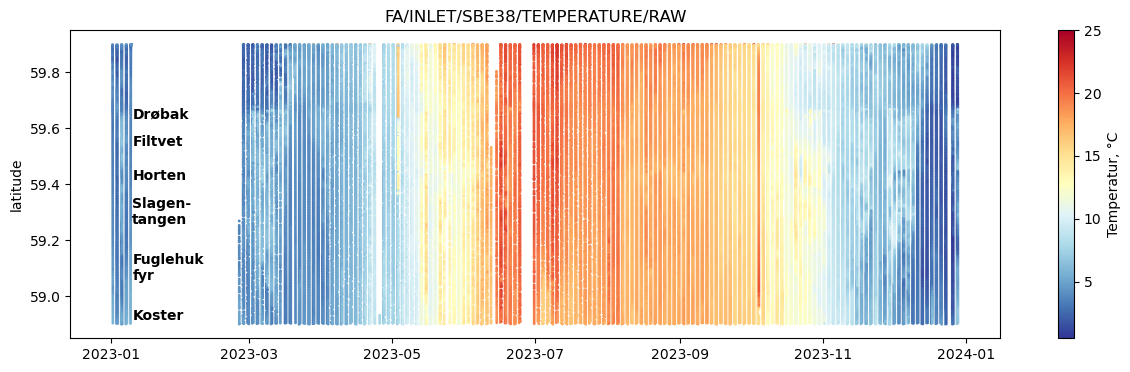

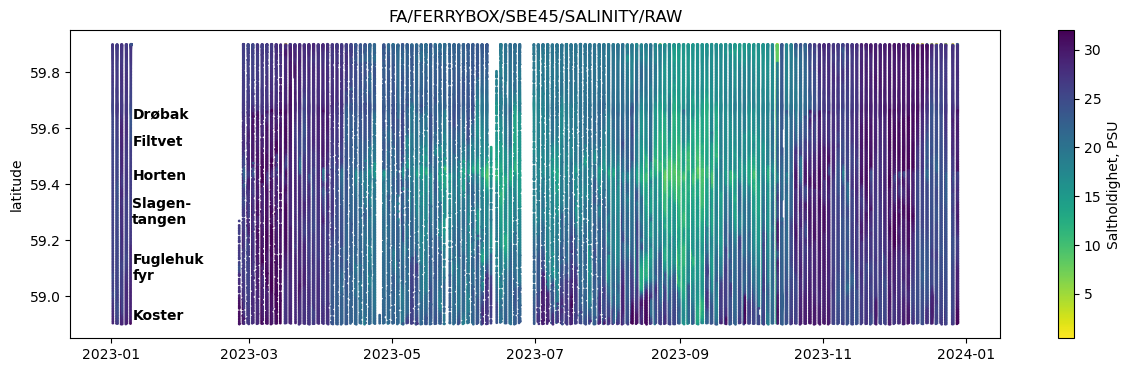

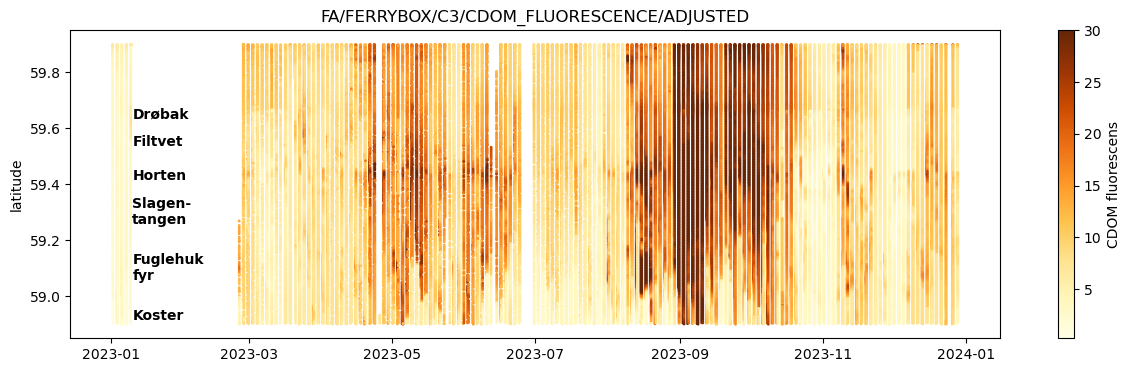

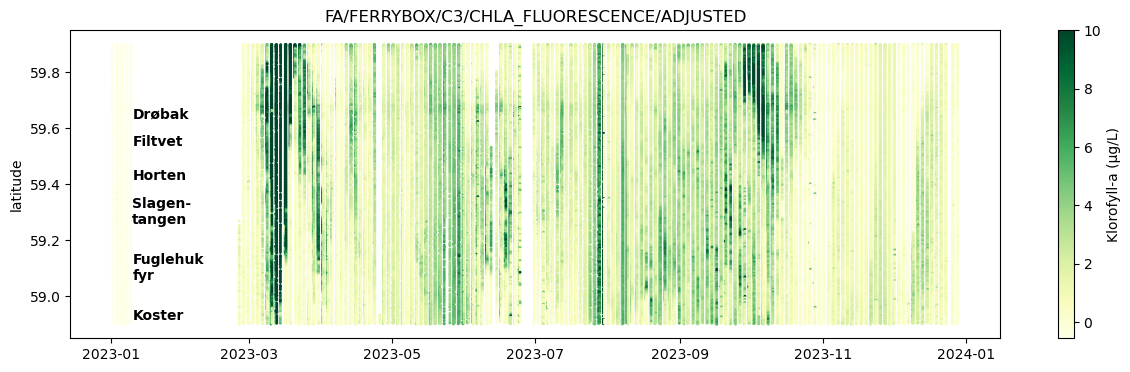

In [22]:
for name in names:
    fig, ax = plt.subplots(figsize=(15,4))
    sc = ax.scatter(df['time'], df['latitude'], c=df[name], s=1, cmap=cmaps[name], vmax=vmaxdict[name])
    ax.set_title(name)
    ax.set_ylabel('latitude')
    
    ax.text(pd.to_datetime('2023-01-10'), 59.65, 'Drøbak', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-10'), 59.55, 'Filtvet', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-10'), 59.43, 'Horten', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-10'), 59.3, 'Slagen-\ntangen', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-10'), 59.1, 'Fuglehuk\nfyr', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-10'), 58.93, 'Koster', fontweight='bold', va='center')
    
    cbar = fig.colorbar(sc, label=labels[name])
    # ax.set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2023-01-01'))
    # plt.savefig(fignames[name] + '_original', dpi=300, bbox_inches='tight')

In [55]:
list(ds.keys())

['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll']

In [58]:
# create xarray dataset (to store interpolated data)
ds = xr.Dataset(coords={'lat': lat_reg, 'datetime': dates})
for name in names:    
    # interpolate variable
    v_reg = griddata((tsec, lat),  # x, y
                     df[name].to_numpy(),  # variable
                     (tsec_regm.ravel(), lat_regm.ravel()),  # Xreg, Yreg
                     method='linear')
    # reshape back to 2D
    vr = v_reg.reshape(tsec_regm.shape)
    # vr[:,mask] = np.nan
    vr = np.clip(vr, 0, vmaxdict[name])
    
    # add interpolated field to dataset
    ds[fignames[name]] = (["lat", "datetime"], vr)

In [59]:
# Define multiple time periods you want to set values to NaN
time_periods = [
    {'start_date': '2023-01-10', 'end_date': '2023-02-20'},
    {'start_date': '2023-07-24', 'end_date': '2023-07-31'},
    {'start_date': '2023-08-06', 'end_date': '2023-08-11'},
    # Add more time periods as needed
]

# Create a boolean mask for each time period and combine them with logical OR
combined_mask = xr.DataArray(False, coords={'lat': ds['lat'], 'datetime': ds['datetime']}, dims=['lat', 'datetime'])
for period in time_periods:
    start_date = pd.to_datetime(period['start_date'])
    end_date = pd.to_datetime(period['end_date'])
    mask = (ds['datetime'] >= start_date) & (ds['datetime'] <= end_date)
    combined_mask |= mask

# Set values to NaN based on the combined mask
ds[['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll']] = ds[['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll']].where(~combined_mask, drop=True)

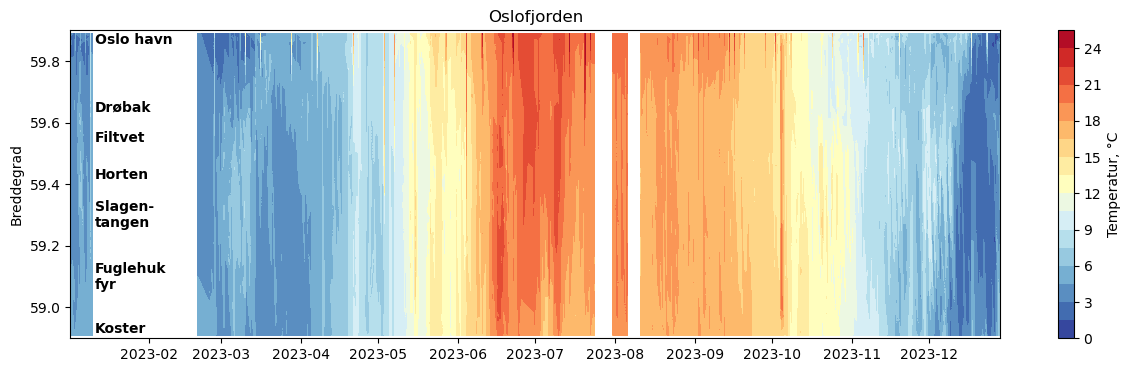

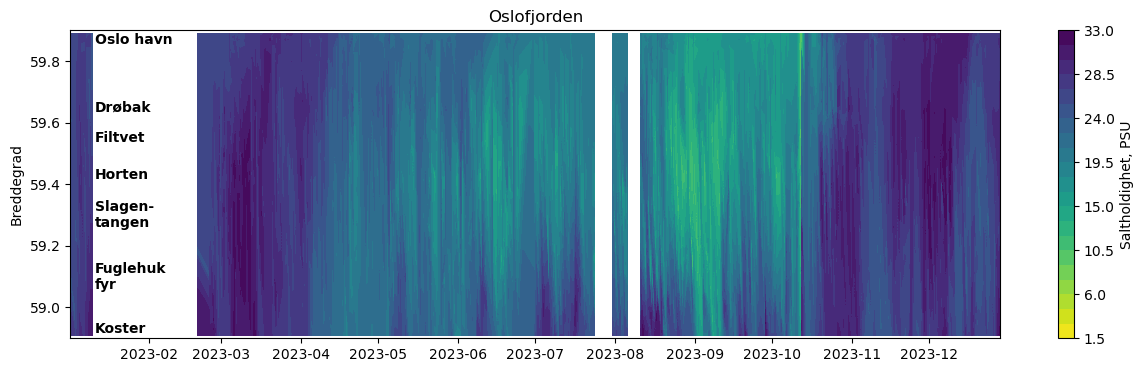

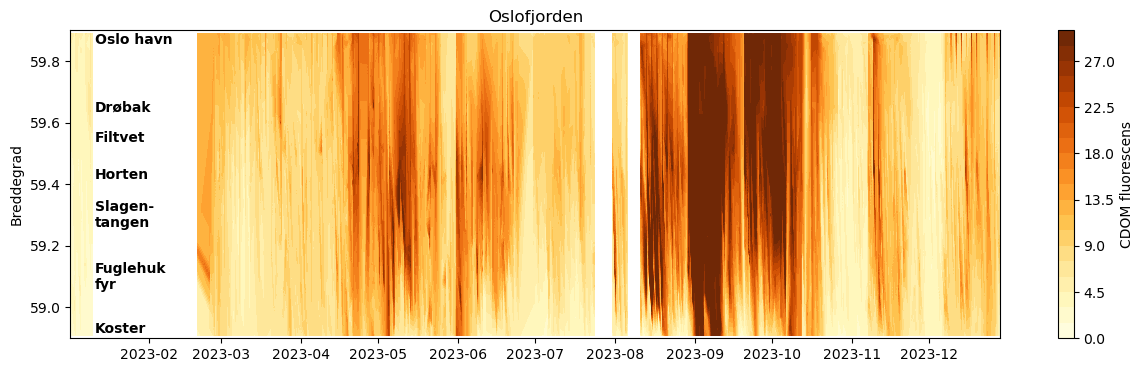

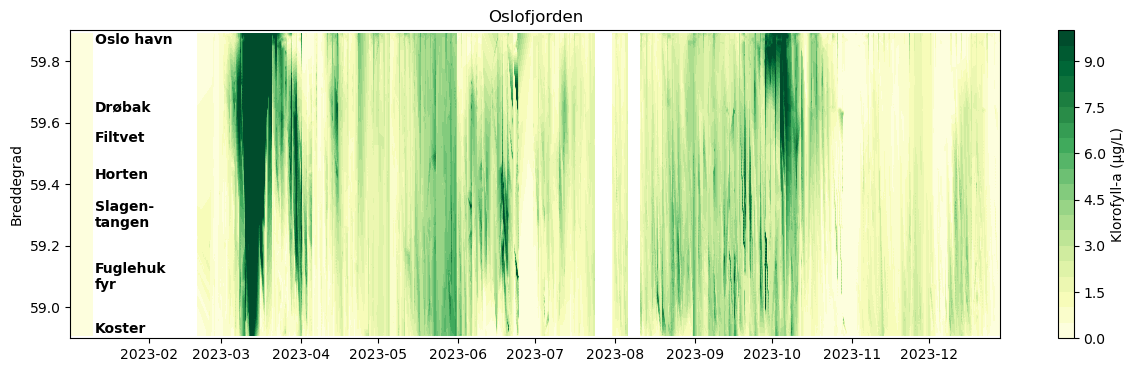

In [61]:
for name in names:
    # contour plot for interpolated data
    fig, ax = plt.subplots(figsize=(15,4))
    
    cf = ax.contourf(dates, lat_reg, ds[fignames[name]], cmap=cmaps[name], levels=20)
    ax.set_title('Oslofjorden')
    ax.set_ylabel('Breddegrad')
    # ax.set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2023-01-01'))
    cbar = fig.colorbar(cf, label=labels[name])
    
    ax.text(pd.to_datetime('2023-01-11'), 59.87, 'Oslo havn', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.65, 'Drøbak', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.55, 'Filtvet', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.43, 'Horten', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.3, 'Slagen-\ntangen', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.1, 'Fuglehuk\nfyr', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 58.93, 'Koster', fontweight='bold', va='center')
    
    plt.savefig(fignames[name] + '_filtered2023', dpi=300, bbox_inches='tight')